# COVID-19 Lung Segmentation and Quantification

This project provides a pipeline for segmenting COVID-19 infected lung regions from DICOM images and quantifying the infection percentage. It leverages the Insight Toolkit (ITK) for image processing, Nibabel and Matplotlib for visualization, and MD.ai for annotation handling.

## Features

- **DICOM Series Reading and Processing:** Reads DICOM series from a directory, handles series details, and converts to ITK images.
- **COVID-19 Infection Segmentation:** Segments potential COVID-19 infected lung regions based on Hounsfield Unit (HU) thresholds (-700 to -200 by default, customizable). Uses thresholding, median filtering for noise reduction, and morphological operations for refinement.
- **Lung Segmentation:** Segments the entire lung region using thresholding, hole filling, distance map, watershed, and median filtering techniques. This creates a precise lung mask for later analysis.
- **Infection Quantification:** Calculates the percentage of infected lung tissue by comparing the COVID-19 segmentation mask with the lung mask.
- **Visualization:** Provides functions to view NIfTI slices (axial, coronal, sagittal) and interactive slice viewing using Matplotlib.
- **Annotation Integration (MD.ai):** Processes MD.ai annotation files to create ground truth segmentation masks from polygon annotations. This allows comparison and validation against the automated segmentation results.

## Requirements

- **Libraries:**
  - `itk` (Insight Toolkit)
  - `numpy`
  - `nibabel`
  - `matplotlib`
  - `pandas`
  - `dicom2nifti` (Optional, for converting DICOM to NIfTI if needed)
  - `mdai` (MD.ai Python client)
  - `tqdm` (Optional, for progress bars)
  - `scikit-image` (for polygon processing)
  - `json` (for JSON file handling)

You can install these using pip:

```bash
pip install itk numpy nibabel matplotlib pandas dicom2nifti mdai tqdm scikit-image
```

Code Execution:

Update the dicom_dir variable in the segment function to the path of your DICOM directory.

Adjust the HU thresholds in segment_covid_lungs() if necessary for different datasets or segmentation requirements.

Update the JSON file path if you are using annotations.

Run the script. The script will perform the segmentation, quantify the infection, and display the results, including visualizations and metrics.

The interactive viewer requires keyboard input (up/down arrows) within the Matplotlib window.

The script will output:

Segmented NIfTI files: covid_segmentation.nii.gz and lungs.nii.gz in the output directory (default: a subdirectory named covid_segmentation or lung within the input DICOM directory).

Infection statistics: Printed to the console, including total voxels, infected voxels, and infection percentage.

Visualizations: Displays slices of the lung mask, COVID-19 segmentation, and overlays.

In [ ]:
import itk
import numpy as np
import os
import sys
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import dicom2nifti
import mdai

In [3]:

# Load the uploaded CSV file to inspect its structure
file_path = '/Users/anurag/Downloads/CSC821 Files/manifest-1608266677008/metadata.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head(), data.columns

(                                          Series UID       Collection   
 0  1.2.826.0.1.3680043.10.474.419639.219217537435...  MIDRC-RICORD-1A  \
 1  1.2.826.0.1.3680043.10.474.419639.302995080539...  MIDRC-RICORD-1A   
 2  1.2.826.0.1.3680043.10.474.419639.108518937868...  MIDRC-RICORD-1A   
 3  1.2.826.0.1.3680043.10.474.419639.314225774870...  MIDRC-RICORD-1A   
 4  1.2.826.0.1.3680043.10.474.419639.336234783057...  MIDRC-RICORD-1A   
 
   3rd Party Analysis              Data Description URI   
 0                 NO  https://doi.org/10.7937/VTW4X588  \
 1                 NO  https://doi.org/10.7937/VTW4X588   
 2                 NO  https://doi.org/10.7937/VTW4X588   
 3                 NO  https://doi.org/10.7937/VTW4X588   
 4                 NO  https://doi.org/10.7937/VTW4X588   
 
                       Subject ID   
 0  MIDRC-RICORD-1A-419639-000082  \
 1  MIDRC-RICORD-1A-419639-000082   
 2  MIDRC-RICORD-1A-419639-000082   
 3  MIDRC-RICORD-1A-419639-000082   
 4  MIDRC-RIC

In [4]:
file_loc = data.groupby('Subject ID')['File Location'].apply(list).reset_index()
data['Series Description'] = [desc if pd.notna(desc) else "NO DETAILS" for desc in data['Series Description']]
series_desc = data.groupby('Subject ID')['Series Description'].apply(list).reset_index()
series_uid=data.groupby('Subject ID')['Series UID'].apply(list).reset_index()
merged_data = pd.merge(file_loc, series_desc, on='Subject ID')
merged_data= pd.merge(merged_data,series_uid,on='Subject ID')
# Display the grouped data
print(merged_data)

# Optionally save the grouped data to a new CSV
output_path = '/Users/anurag/Downloads/CSC821 Files/manifest-1608266677008/grouped_by_subject_id.csv'
merged_data.to_csv(output_path, index=False)
print(f"Grouped data saved to: {output_path}")

                        Subject ID   
0    MIDRC-RICORD-1A-419639-000082  \
1    MIDRC-RICORD-1A-419639-000361   
2    MIDRC-RICORD-1A-419639-000421   
3    MIDRC-RICORD-1A-419639-000582   
4    MIDRC-RICORD-1A-419639-000800   
..                             ...   
105   MIDRC-RICORD-1A-SITE2-000259   
106   MIDRC-RICORD-1A-SITE2-000272   
107   MIDRC-RICORD-1A-SITE2-000275   
108   MIDRC-RICORD-1A-SITE2-000293   
109   MIDRC-RICORD-1A-SITE2-000296   

                                         File Location   
0    [./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-0000...  \
1    [./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-0003...   
2    [./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-0004...   
3    [./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-0005...   
4    [./MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-0008...   
..                                                 ...   
105  [./MIDRC-RICORD-1A/MIDRC-RICORD-1A-SITE2-00025...   
106  [./MIDRC-RICORD-1A/MIDRC-RICORD-1A-SITE2-00027...   
107  [./MIDRC-RICORD-

In [5]:
def view_nifti_slices(nifti_path, slice_indices=None, cmap='gray'):
    # Load the NIfTI file
    img = nib.load(nifti_path)
    data = img.get_fdata()
    
    # Get dimensions
    x, y, z = data.shape
    
    # If no slice indices provided, take middle slices
    if slice_indices is None:
        slice_indices = [x//2, y//2, z//2]
    
    # Create a figure with three subplots (one for each orientation)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Sagittal view (YZ plane)
    ax1.imshow(np.rot90(data[slice_indices[0], :, :]), cmap=cmap)
    ax1.set_title(f'Sagittal Slice {slice_indices[0]}')
    
    # Coronal view (XZ plane)
    ax2.imshow(np.rot90(data[:, slice_indices[1], :]), cmap=cmap)
    ax2.set_title(f'Coronal Slice {slice_indices[1]}')
    
    # Axial view (XY plane)
    ax3.imshow(np.rot90(data[:, :, slice_indices[2]]), cmap=cmap)
    ax3.set_title(f'Axial Slice {slice_indices[2]}')
    
    plt.tight_layout()
    plt.show()

def view_nifti_interactive(nifti_path):

    img = nib.load(nifti_path)
    data = img.get_fdata()
    
    class IndexTracker:
        def __init__(self, ax, X):
            self.ax = ax
            self.X = X
            self.slices = X.shape[2]
            self.ind = self.slices//2
            
            self.im = ax.imshow(np.rot90(self.X[:, :, self.ind]), cmap='gray')
            self.update()
    
        def onscroll(self, event):
            if event.key == 'up':
                self.ind = (self.ind + 1) % self.slices
            elif event.key == 'down':
                self.ind = (self.ind - 1) % self.slices
            self.update()
    
        def update(self):
            self.im.set_data(np.rot90(self.X[:, :, self.ind]))
            self.ax.set_title(f'Slice {self.ind}/{self.slices}')
            self.im.axes.figure.canvas.draw()
    
    fig, ax = plt.subplots()
    tracker = IndexTracker(ax, data)
    fig.canvas.mpl_connect('key_press_event', tracker.onscroll)
    plt.show()


In [6]:
def get_dicom_series_filenames(dicom_directory):
    # Find all .dcm files, including in subdirectories
    dicom_files = []
    for root, _, files in os.walk(dicom_directory):
        dicom_files.extend([
            os.path.join(root, f) for f in files 
            if f.lower().endswith(('.dcm', '.dicom'))
        ])
    
    # Sort files to ensure correct slice order
    dicom_files = sorted(dicom_files)
    
    if not dicom_files:
        raise ValueError(f"No DICOM files found in {dicom_directory}")
    
    return dicom_files

In [ ]:
class COVIDLungSegmentation:
    
    def __init__(self, dicom_directory):

        self.dicom_directory = dicom_directory
        
        # Specific HU ranges for COVID-19 lung involvement
        self.lower_threshold = -700  # Lung air/ground-glass opacity lower bound
        self.upper_threshold = -200  # Consolidation upper bound
        
        # Initialize ITK image types
        self.PixelType = itk.ctype("short") 
        self.Dimension = 3
        self.ImageType = itk.Image[self.PixelType, self.Dimension]
        
        # Set up DICOM series reader
        self.setup_dicom_reader()
    
    def setup_dicom_reader(self):
        # Create DICOM name generator
        self.names_generator = itk.GDCMSeriesFileNames.New()
        self.names_generator.SetUseSeriesDetails(True)
        self.names_generator.AddSeriesRestriction("0008|0021")
        self.names_generator.SetGlobalWarningDisplay(False)
        self.names_generator.SetDirectory(self.dicom_directory)
        
        # Get series UIDs
        self.series_uids = self.names_generator.GetSeriesUIDs()
        
        if not self.series_uids:
            raise ValueError(f"No DICOM series found in {self.dicom_directory}")
        
        # Get filenames for the first series
        self.series_identifier = self.series_uids[0]
        self.filenames = self.names_generator.GetFileNames(self.series_identifier)
        
        # Set up image reader
        self.image_reader = itk.ImageSeriesReader[self.ImageType].New()
        self.dicom_io = itk.GDCMImageIO.New()
        self.image_reader.SetImageIO(self.dicom_io)
        self.image_reader.SetFileNames(self.filenames)
        self.image_reader.ForceOrthogonalDirectionOff()
    
    def read_dicom_series(self):
        try:
            self.image_reader.Update()
            return self.image_reader.GetOutput()
        except Exception as e:
            print(f"Error reading DICOM series: {e}")
            return None
    
    def segment_covid_lungs(self,output_directory=None,lower_threshold=None,upper_threshold=None):
        # Use custom thresholds if provided
        lt = lower_threshold if lower_threshold is not None else self.lower_threshold
        ut = upper_threshold if upper_threshold is not None else self.upper_threshold
        
        # Prepare output directory
        if output_directory is None:
            output_directory = os.path.join(self.dicom_directory, 'covid_segmentation')
        os.makedirs(output_directory, exist_ok=True)
        
        # Read the image series
        input_image = self.read_dicom_series()
        if input_image is None:
            return None
            
        # Convert to float for processing
        FloatImageType = itk.Image[itk.F, self.Dimension]
        castFilter = itk.CastImageFilter[self.ImageType, FloatImageType].New()
        castFilter.SetInput(input_image)
        
        # Threshold segmentation
        thresholdFilter = itk.BinaryThresholdImageFilter[FloatImageType, FloatImageType].New()
        thresholdFilter.SetInput(castFilter.GetOutput())
        thresholdFilter.SetLowerThreshold(lt)
        thresholdFilter.SetUpperThreshold(ut)
        thresholdFilter.SetInsideValue(1)
        thresholdFilter.SetOutsideValue(0)
        
        # Morphological operations to clean up the segmentation
        kernel = itk.FlatStructuringElement[self.Dimension].Ball(2)
        
        # median filter to remove small noise salt and pepper
        medianFilter = itk.MedianImageFilter[FloatImageType, FloatImageType].New()
        medianFilter.SetInput(thresholdFilter.GetOutput())
        medianFilter.SetRadius(2)
        medianFilter.Update()
        
        # Convert back to binary image
        BinaryImageType = itk.Image[itk.UC, self.Dimension]
        binaryCastFilter = itk.CastImageFilter[FloatImageType, BinaryImageType].New()
        binaryCastFilter.SetInput(medianFilter.GetOutput())
        binaryCastFilter.Update()
        
        if output_directory:
            writer = itk.ImageFileWriter[BinaryImageType].New()
            writer.SetFileName(os.path.join(output_directory, "covid_segmentation.nii.gz"))
            writer.SetInput(binaryCastFilter.GetOutput())
            writer.Update()
        
        print("Starting interactive viewer (use up/down arrow keys to navigate slices)...")
        view_nifti_slices(os.path.join(output_directory, "covid_segmentation.nii.gz"))
        
        return input_image,binaryCastFilter.GetOutput()
    
    def segment_lungs(self,input_image,output_directory=None):
        
        if output_directory is None:
            output_directory = os.path.join(self.dicom_directory, 'lung')
        os.makedirs(output_directory, exist_ok=True)
                
        # print(itk.size(input_image))  # Check the dimensions of the original image
        # print(itk.GetArrayViewFromImage(input_image).shape)  # Validate dimensions
        # image_array = itk.GetArrayViewFromImage(input_image)
        # plt.hist(image_array.flatten(), bins=256, range=(-2000, 2000))
        # plt.show()
        # image_array = itk.GetArrayFromImage(input_image)
        # print("Image HU Range:")
        # print(f"Minimum: {image_array.min()}")
        # print(f"Maximum: {image_array.max()}")
        # print(f"Mean: {image_array.mean()}")
        
        if input_image is None:
            print('returning none')
            return None  

        # Convert to float for initial processing
        FloatImageType = itk.Image[itk.F, self.Dimension]
        BinaryImageType = itk.Image[itk.UC, self.Dimension]

        # Initial thresholding to get lung tissue
        castFilter = itk.CastImageFilter[self.ImageType, FloatImageType].New()
        castFilter.SetInput(input_image)

        thresholdFilter = itk.BinaryThresholdImageFilter[FloatImageType, FloatImageType].New()
        thresholdFilter.SetInput(castFilter.GetOutput())
        thresholdFilter.SetLowerThreshold(-950)
        thresholdFilter.SetUpperThreshold(-300)
        thresholdFilter.SetInsideValue(1)
        thresholdFilter.SetOutsideValue(0)
        thresholdFilter.Update()

        # Convert to binary image
        binaryCastFilter = itk.CastImageFilter[FloatImageType, BinaryImageType].New()
        binaryCastFilter.SetInput(thresholdFilter.GetOutput())
        binaryCastFilter.Update()  


        # # Hole filling
        holeFillFilter = itk.BinaryFillholeImageFilter[BinaryImageType].New()
        holeFillFilter.SetInput(binaryCastFilter.GetOutput())
        holeFillFilter.SetForegroundValue(1)
        holeFillFilter.Update()

        
        FloatImageType = itk.Image[itk.F, self.Dimension]  # Define explicitly here
        castFilter = itk.CastImageFilter[BinaryImageType, FloatImageType].New() # Cast from binary TO float
        castFilter.SetInput(holeFillFilter.GetOutput())
        castFilter.Update()


        # Now use the casted image as input to distance map:
        distanceFilter = itk.SignedMaurerDistanceMapImageFilter[FloatImageType, FloatImageType].New()
        distanceFilter.SetInput(castFilter.GetOutput()) 
        distanceFilter.SetInsideIsPositive(True)
        distanceFilter.SetUseImageSpacing(True)
        distanceFilter.Update()
        distance_image=distanceFilter.GetOutput()


        watershedFilter = itk.WatershedImageFilter[FloatImageType].New()
        watershedFilter.SetInput(distance_image)
        watershedFilter.SetThreshold(0.001)  
        watershedFilter.SetLevel(0.01)  
        watershedFilter.Update()

        
        watershed_np = itk.GetArrayViewFromImage(watershedFilter.GetOutput())
        labels, counts = np.unique(watershed_np[watershed_np != 0], return_counts=True)
        largest_region_label = labels[np.argmax(counts)]
        
        binary_mask = np.where(watershed_np == largest_region_label, 1, 0).astype(np.uint8)
        binary_image = itk.GetImageFromArray(binary_mask)
        binary_image.CopyInformation(input_image)
        
        medianFilter = itk.MedianImageFilter[BinaryImageType, BinaryImageType].New()
        medianFilter.SetInput(binary_image)
        medianFilter.SetRadius(5)
        medianFilter.Update() 
        
        if output_directory:
            writer = itk.ImageFileWriter[BinaryImageType].New()
            writer.SetFileName(os.path.join(output_directory, "lungs.nii.gz"))
            writer.SetInput(medianFilter.GetOutput())
            writer.Update()
        
        print("Starting interactive viewer (use up/down arrow keys to navigate slices)...")
        view_nifti_slices(os.path.join(output_directory, "lungs.nii.gz"))
        
        return medianFilter.GetOutput()

    def quantify_infection(self,lung_mask,segmentation_mask):
        # Convert mask to numpy for analysis
        mask_array = itk.GetArrayFromImage(segmentation_mask)
        lung_array= itk.GetArrayFromImage(lung_mask)
        # Calculate infection metrics
        total_voxels = np.sum(lung_array > 0)
        infected_voxels = np.sum(mask_array > 0)
        infection_percentage = (infected_voxels / total_voxels) * 100
        
        return {
            'total_voxels': total_voxels,
            'infected_voxels': infected_voxels,
            'infection_percentage': infection_percentage
        }
        


In [8]:
def segment(dicom_dir):    
    try:
        segmenter = COVIDLungSegmentation(dicom_dir)
        
        print("Performing segmentation...")
        input_volume,mask = segmenter.segment_covid_lungs(
            lower_threshold=-700,  
            upper_threshold=-200   
        )
        lung_mask= segmenter.segment_lungs(input_volume)
        if mask:
            print("Calculating infection statistics...")
            infection_stats = segmenter.quantify_infection(lung_mask,mask)
            print("\nInfection Statistics:")
            for key, value in infection_stats.items():
                print(f"{key}: {value}")
        else:
            print("Segmentation failed.")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        
    return input_volume,lung_mask,mask

Performing segmentation...
Starting interactive viewer (use up/down arrow keys to navigate slices)...


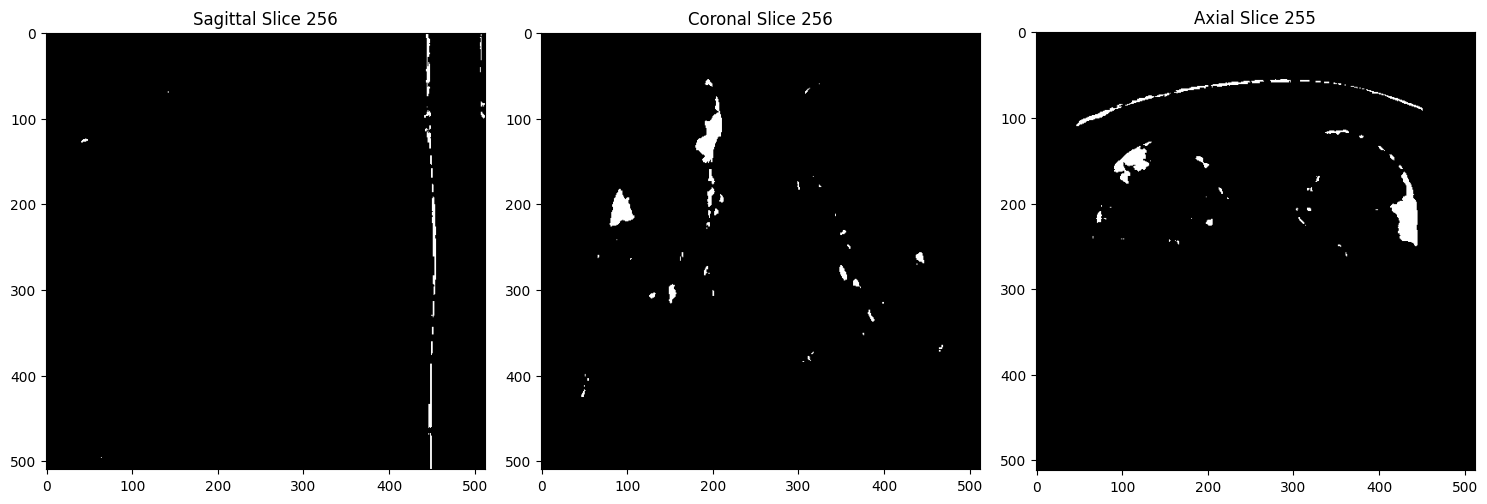

Starting interactive viewer (use up/down arrow keys to navigate slices)...


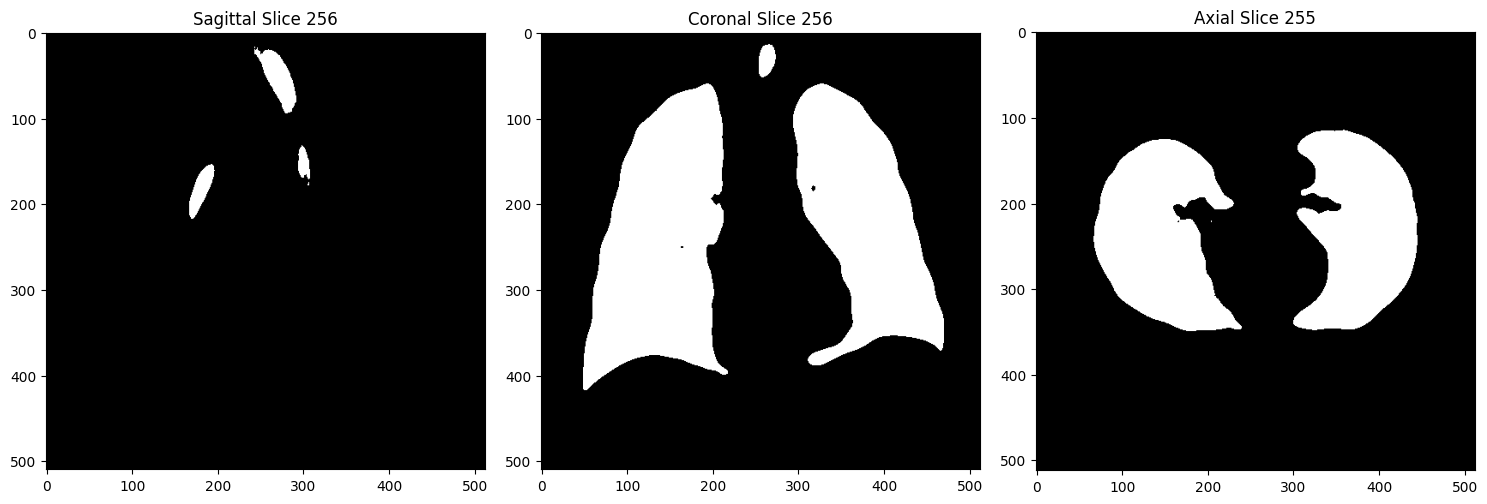

Calculating infection statistics...

Infection Statistics:
total_voxels: 13982295
infected_voxels: 1557816
infection_percentage: 11.141346967718817


In [9]:
input_volume,lung_mask,segmentation_mask=segment( '/Users/anurag/Downloads/CSC821 Files/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/3.000000-0.625mm bone alg-26970')

itkSize3 ([512, 512, 510])
(510, 512, 512)


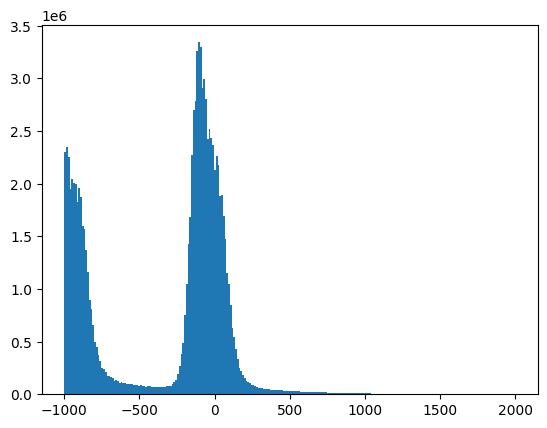

Image HU Range:
Minimum: -3024
Maximum: 2272
Mean: -929.7951403374766
-630
-630


In [ ]:
print(itk.size(input_volume))  # Check the dimensions of the original image
print(itk.GetArrayViewFromImage(input_volume).shape)  # Validate dimensions
image_array = itk.GetArrayViewFromImage(input_volume)
plt.hist(image_array.flatten(), bins=256, range=(-1000, 2000))
plt.show()

image_array = itk.GetArrayFromImage(input_volume)
print("Image HU Range:")
print(f"Minimum: {image_array.min()}")
print(f"Maximum: {image_array.max()}")
print(f"Mean: {image_array.mean()}")

In [11]:
import json

# Load the JSON file
with open('/Users/anurag/Downloads/MIDRC-RICORD-1a_annotations_labelgroup_all_2020-Dec-8.json', 'r') as file:
    data = json.load(file)

# Access label groups and annotations
label_groups = data.get('labelGroups', [])
for group in label_groups:
    for label in group.get('labels', []):
        print(f"Label Name: {label['name']}, Type: {label['type']}")


Label Name: Infectious opacity, Type: LOCAL
Label Name: Infectious TIB/micronodules, Type: LOCAL
Label Name: Infectious cavity, Type: LOCAL
Label Name: Noninfectious nodule/mass, Type: LOCAL
Label Name: Atelectasis, Type: LOCAL
Label Name: Other noninfectious opacity, Type: LOCAL
Label Name: Typical, Type: GLOBAL
Label Name: Indeterminate, Type: GLOBAL
Label Name: Atypical, Type: GLOBAL
Label Name: Negative for pneumonia, Type: GLOBAL
Label Name: Halo sign, Type: GLOBAL
Label Name: Reversed halo sign, Type: GLOBAL
Label Name: Reticular pattern w/o parenchymal opacity, Type: GLOBAL
Label Name: Perilesional vessel enlargement, Type: GLOBAL
Label Name: Bronchial wall thickening, Type: GLOBAL
Label Name: Bronchiectasis, Type: GLOBAL
Label Name: Subpleural curvilinear line, Type: GLOBAL
Label Name: Effusion, Type: GLOBAL
Label Name: Pleural thickening, Type: GLOBAL
Label Name: Pneumothorax, Type: GLOBAL
Label Name: Pericardial effusion, Type: GLOBAL
Label Name: Lymphadenopathy, Type: GLOBAL

In [12]:
local_annotations = []
for group in data.get('labelGroups', []):
    for label in group.get('labels', []):
        if label['type'] == 'LOCAL':
            local_annotations.append(label['name'])

local_annotations= set(local_annotations)
local_annotations
local_annotations= list(local_annotations)
local_annotations


['Noninfectious nodule/mass',
 'Infectious cavity',
 'Atelectasis',
 'Infectious TIB/micronodules',
 'Other noninfectious opacity',
 'Infectious opacity']

In [13]:
results = mdai.common_utils.json_to_dataframe('/Users/anurag/Downloads/CSC821 Files/MIDRC-RICORD-1a_annotations_labelgroup_all_2020-Dec-8.json')
annotations_df = results['annotations']
print(f"{annotations_df.shape[0]} annotations loaded")


26408 annotations loaded


In [14]:
annotations_df.columns

Index(['id', 'parentId', 'isImported', 'createdAt', 'createdById', 'updatedAt',
       'updatedById', 'labelId', 'annotationNumber', 'height', 'width', 'data',
       'note', 'radlexTagIds', 'reviewsPositiveCount', 'reviewsNegativeCount',
       'StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID', 'dataset',
       'labelGroupId', 'labelGroupName', 'annotationMode', 'color',
       'description', 'labelName', 'radlexTagIdsLabel', 'scope',
       'parentLabelId', 'datasetId', 'number'],
      dtype='object')

In [15]:
annotations_df['SeriesInstanceUID'].describe()

count                                       25605
unique                                        118
top       1.2.826.0.1.3680043.10.474.660042.25679
freq                                          933
Name: SeriesInstanceUID, dtype: object

In [16]:
annotations_df['data'].describe()

count                                                 25604
unique                                                25601
top       {'vertices': [[421.50237, 314.198], [417.73657...
freq                                                      2
Name: data, dtype: object

In [17]:
all_series_uids = annotations_df['SeriesInstanceUID'].unique()
all_series_uids = all_series_uids[~pd.isnull(all_series_uids)]

In [18]:
csv_path ='/Users/anurag/Downloads/CSC821 Files/manifest-1608266677008/grouped_by_subject_id.csv'
grouped_data = pd.read_csv(csv_path)
series_uid = '1.2.826.0.1.3680043.10.474.660042.25679'
instance_path=''
for _, row in grouped_data.iterrows():
    subject_id = row['Subject ID']    
    series_desc= eval(row['Series Description'])
    series_uid_df= eval(row['Series UID'])
    file_paths = eval(row['File Location'])
    base_directory = '/Users/anurag/Downloads/CSC821 Files/manifest-1608266677008'
    file_paths = [os.path.join(base_directory, path.strip("./")) for path in file_paths]
    for series_uid_single in series_uid_df:
        if series_uid_single== series_uid:
            index = series_uid_df.index(series_uid_single)
            instance_path= file_paths[index]

print(instance_path)

/Users/anurag/Downloads/CSC821 Files/manifest-1608266677008/MIDRC-RICORD-1A/MIDRC-RICORD-1A-660042-000107/11-20-2008-NA-NA-25678/4.000000-NA-25679


Performing segmentation...
Starting interactive viewer (use up/down arrow keys to navigate slices)...


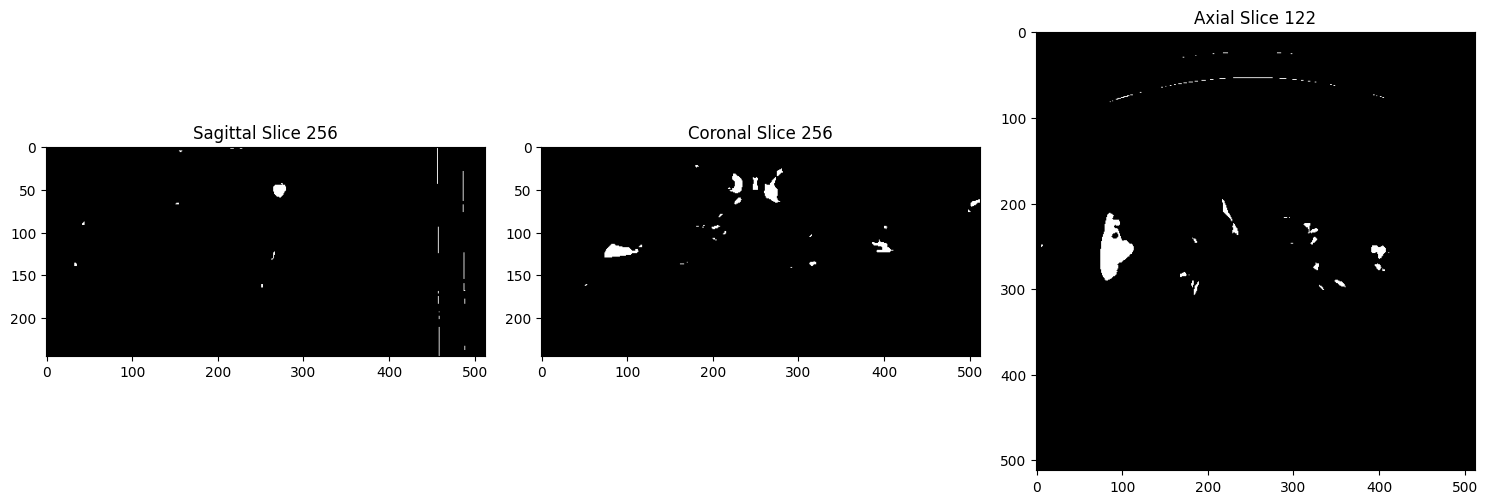

Starting interactive viewer (use up/down arrow keys to navigate slices)...


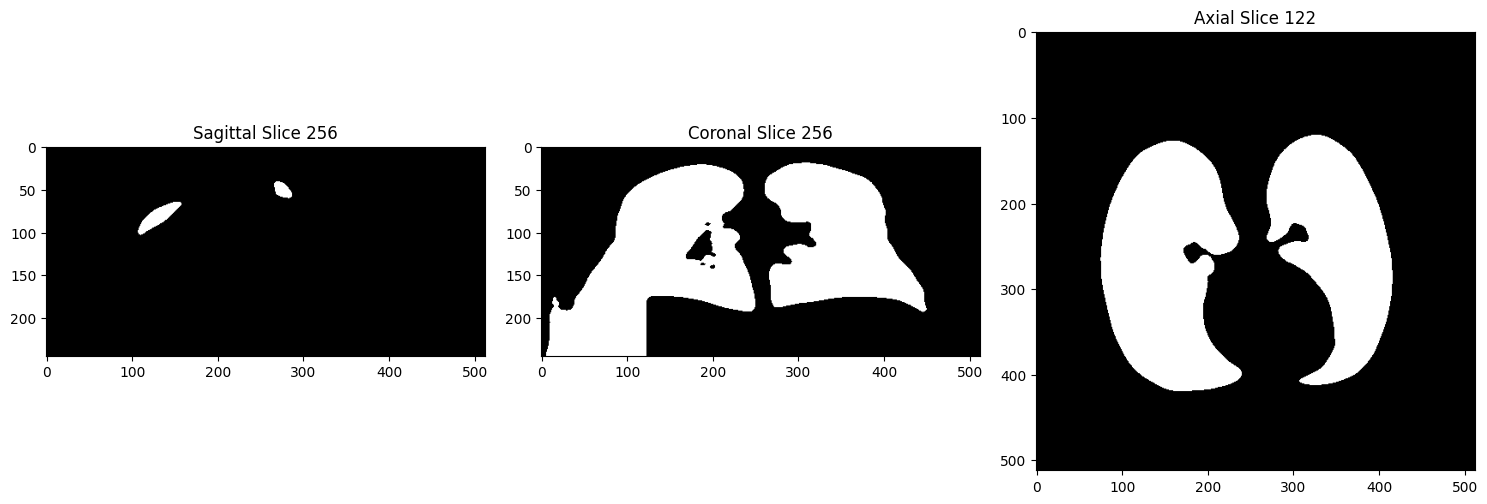

Calculating infection statistics...

Infection Statistics:
total_voxels: 9030300
infected_voxels: 205420
infection_percentage: 2.274785998250335


In [19]:
input_volume,lung_mask,segmentation_mask=segment(instance_path)

itkSize3 ([512, 512, 244])
(244, 512, 512)


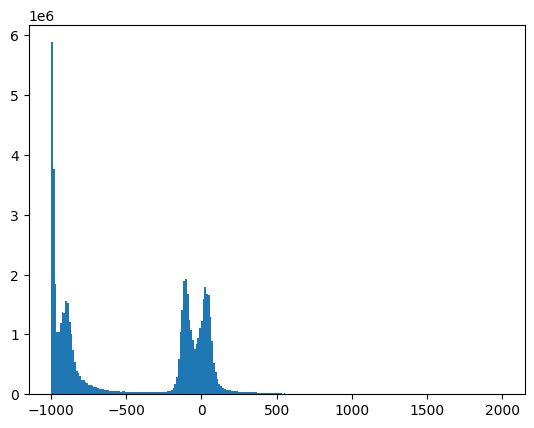

Image HU Range:
Minimum: -1024
Maximum: 1549
Mean: -502.6462606992878
-753.0


In [20]:
print(itk.size(input_volume))  # Check the dimensions of the original image
print(itk.GetArrayViewFromImage(input_volume).shape)  # Validate dimensions
image_array = itk.GetArrayViewFromImage(input_volume)
plt.hist(image_array.flatten(), bins=256, range=(-1000, 2000))
plt.show()

image_array = itk.GetArrayFromImage(input_volume)
print("Image HU Range:")
print(f"Minimum: {image_array.min()}")
print(f"Maximum: {image_array.max()}")
print(f"Mean: {image_array.mean()}")
print(np.median(image_array))

In [21]:
# Step 1: Filter annotations by SeriesInstanceUID (adjust SeriesInstanceUID as needed)
series_uid = '1.2.826.0.1.3680043.10.474.660042.25679'
series_annotations = annotations_df[annotations_df['SeriesInstanceUID'] == series_uid]
series_annotations['data']

3740    {'vertices': [[383.22299, 303.95243], [381.193...
3741    {'vertices': [[381.19326, 311.05649], [379.163...
3742    {'vertices': [[379.16353, 307.50446], [376.626...
3743    {'vertices': [[396.41625, 274.01388], [394.893...
3744    {'vertices': [[386.77502, 272.99901], [386.267...
                              ...                        
4672    {'vertices': [[389.31219, 168.97522], [389.819...
4673    {'vertices': [[369.5223, 180.13875], [370.5371...
4674    {'vertices': [[376.62636, 171.51239], [376.626...
4675    {'vertices': [[371.59398, 171.54887], [373.999...
4676    {'vertices': [[295.08271, 111.8797], [295.5639...
Name: data, Length: 933, dtype: object

In [ ]:
import numpy as np
import pandas as pd
import json
from skimage.draw import polygon
import matplotlib.pyplot as plt
# Step 2: Initialize the 3D volume
# You need to know the dimensions of the image, e.g., height, width, and depth (e.g., number of slices)
depth,width, height = lung_mask.shape
segmentation_volume = np.zeros((depth,width, height), dtype=np.uint8)  # Binary mask

# Step 3: Loop through each annotation to build the segmentation mask
for _, annotation in series_annotations.iterrows():
    try:
        annotation_data = annotation['data'] # Parse the 'data' field (containing polygons)
        vertices = annotation_data.get('vertices', [])
        # Determine the slice (z-coordinate) for this annotation
        slice_index = int(annotation['annotationNumber']) 
        # Step 3: Create a 2D mask for this slice
        cc, rr = polygon([v[0] for v in vertices], [v[1] for v in vertices], shape=(width, height))
        # Step 4: Fill the 2D mask on the corresponding slice of the 3D volume
        segmentation_volume[slice_index,cc, rr] = 1  # Mark the region in the 3D volume
    except json.JSONDecodeError:
        print(f"Error decoding data for annotation ID {annotation['id']}")


In [23]:
lung_array = itk.GetArrayFromImage(lung_mask)
infected_voxels_segmentation_array=itk.GetArrayFromImage(segmentation_mask)
total_voxels= np.sum(lung_array > 0)
print(total_voxels)
infected_voxels_annotation = np.sum(segmentation_volume > 0)
print(infected_voxels_annotation)
infected_voxels_segmentation = np.sum(infected_voxels_segmentation_array > 0)
print(infected_voxels_segmentation)
infection_percentage_annotation = (infected_voxels_annotation / total_voxels) * 100
print(infection_percentage_annotation)
infection_percentage_segmentation = (infected_voxels_segmentation / total_voxels) * 100
print(infection_percentage_segmentation)

9030300
304233
205420
3.3690242849074785
2.274785998250335


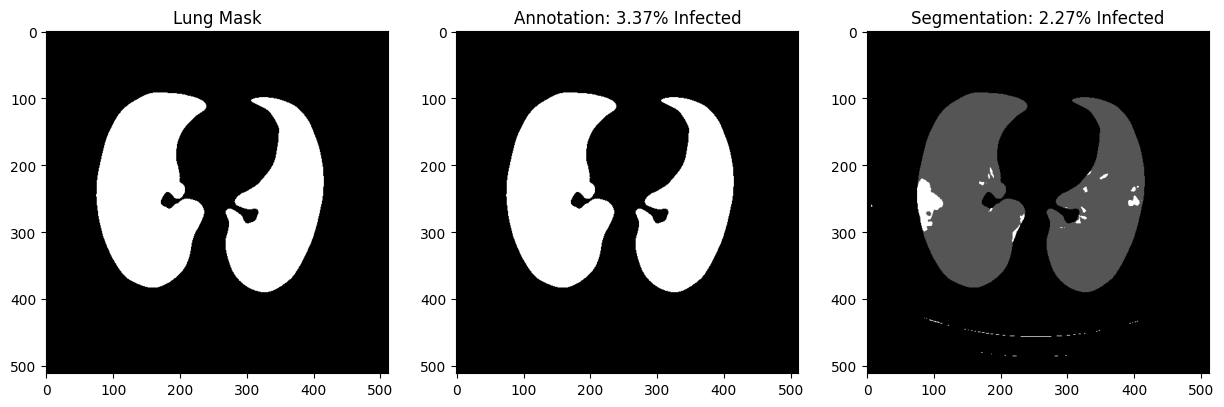

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Lung Mask
axes[0].imshow(lung_array[lung_array.shape[0] // 2], cmap='gray')  
axes[0].set_title("Lung Mask")

    # 2. Infection Overlay (Annotation)
overlay_annotation = np.copy(lung_array)
overlay_annotation[segmentation_volume > 0] = 2  
axes[1].imshow(overlay_annotation[overlay_annotation.shape[0] // 2], cmap='gray') 
axes[1].set_title(f"Annotation: {infection_percentage_annotation:.2f}% Infected")

# 3. Infection Overlay (Segmentation)
overlay_segmentation = np.copy(lung_array)
overlay_segmentation[infected_voxels_segmentation_array > 0] = 3 
axes[2].imshow(overlay_segmentation[overlay_segmentation.shape[0] // 2], cmap='gray')
axes[2].set_title(f"Segmentation: {infection_percentage_segmentation:.2f}% Infected")


plt.show()